# Target 변수 관계 분석 및 Insight

In [ ]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Apple 기본 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# train 데이터 로드
df = pd.read_csv("../data/raw/train.csv")

/tmp/ipykernel_447677/104270832.py:2: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/train.csv")


In [4]:
# 테스트 전처리 코드
df = df.rename(columns={'전용면적(㎡)':'전용면적'})

df['자치구'] = df['시군구'].map(lambda x : x.split()[1])
df['법정동'] = df['시군구'].map(lambda x : x.split()[2])

## 계약일자 datetime으로 변경
df['계약일자'] = df.apply(lambda row: f"{row['계약년월']:06d}{row['계약일']:02d}", axis=1)
df['계약일자'] = pd.to_datetime(df['계약일자'], format='%Y%m%d')

## 계약년도 및 계약 월 생성
df['계약년도'] = df['계약일자'].dt.year
df['계약월'] = df['계약일자'].dt.month

## 연식
df['연식'] = df['계약년도'] - df['건축년도']
# df[df['연식'] < 0]
df['연식'] = df['연식'].clip(lower=0)

## 1. Target 변수 분포 확인

### 1-1 Target 변수 분포 확인 결과
- 집값의 분포가 왼쪽으로 치우쳐져 있음
- 일부 고가의 아파트로 인해 오른쪽 꼬리가 긴 편

In [5]:
display(df['target'].describe())

count   1,118,822
mean       57,992
std        46,426
min           350
25%        30,500
50%        44,800
75%        69,800
max     1,450,000
Name: target, dtype: float64

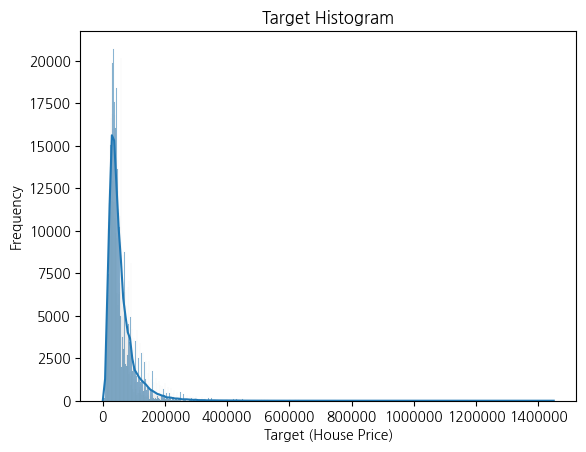

In [6]:
sns.histplot(df["target"], kde=True)

ax = plt.gca()
ax.ticklabel_format(style='plain', axis='x')
ax.ticklabel_format(style='plain', axis='y')

plt.title("Target Histogram")
plt.xlabel("Target (House Price)")
plt.ylabel("Frequency")
plt.show()

### 1-2 Target 변수 log1p, Box-Cox, 제곱근 변환 적용
- 로그 변환(log1p) 후 분포가 전보다 정규분포 형태에 가까워짐 (변환 후에도 꼬리가 긴 편)
- 로그 변환 여부 고려 필요

In [5]:
# 로그 변환 (log1p) 적용
df["log_target"] = np.log1p(df["target"])

In [6]:
from scipy import stats

# Box-Cox 변환 적용
transformed_data, fitted_lambda = stats.boxcox(df["target"])

print(f"Optimal lambda: {fitted_lambda}")

df["boxcox_target"] = transformed_data

Optimal lambda: -0.1345682113520133


In [7]:
# 제곱근 변환 적용
df["sqrt_target"] = np.sqrt(df["target"])

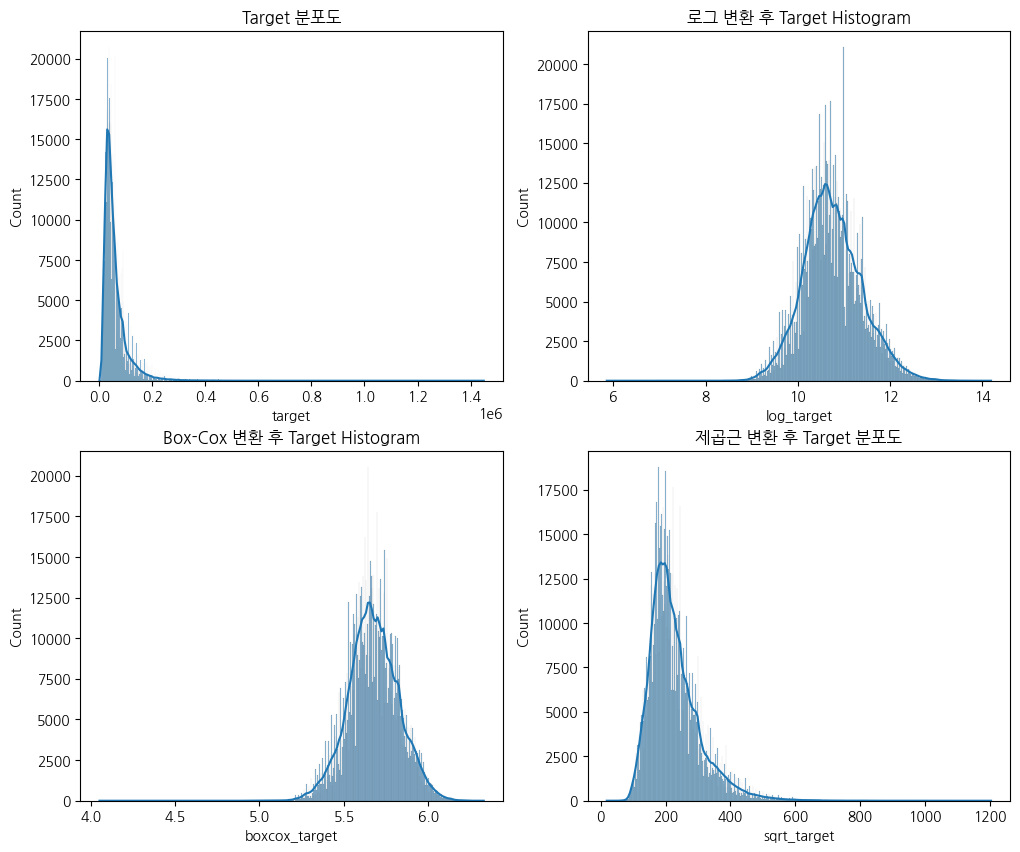

In [8]:
# target 및 각 변환 적용 후 target histogram 
plt.figure(figsize=(12, 10))

# target
plt.subplot(2, 2, 1)
sns.histplot(df["target"], kde=True)
plt.title("Target 분포도")

# 로그 변환 후 target
plt.subplot(2, 2, 2)
sns.histplot(df["log_target"], kde=True)
plt.title("로그 변환 후 Target Histogram")

# Box-Cox 변환 후 target
plt.subplot(2, 2, 3)
sns.histplot(df["boxcox_target"], kde=True)
plt.title("Box-Cox 변환 후 Target Histogram")

# 제곱근 변환 후 target
plt.subplot(2, 2, 4)
sns.histplot(df["sqrt_target"], kde=True)
plt.title("제곱근 변환 후 Target 분포도")

plt.show()

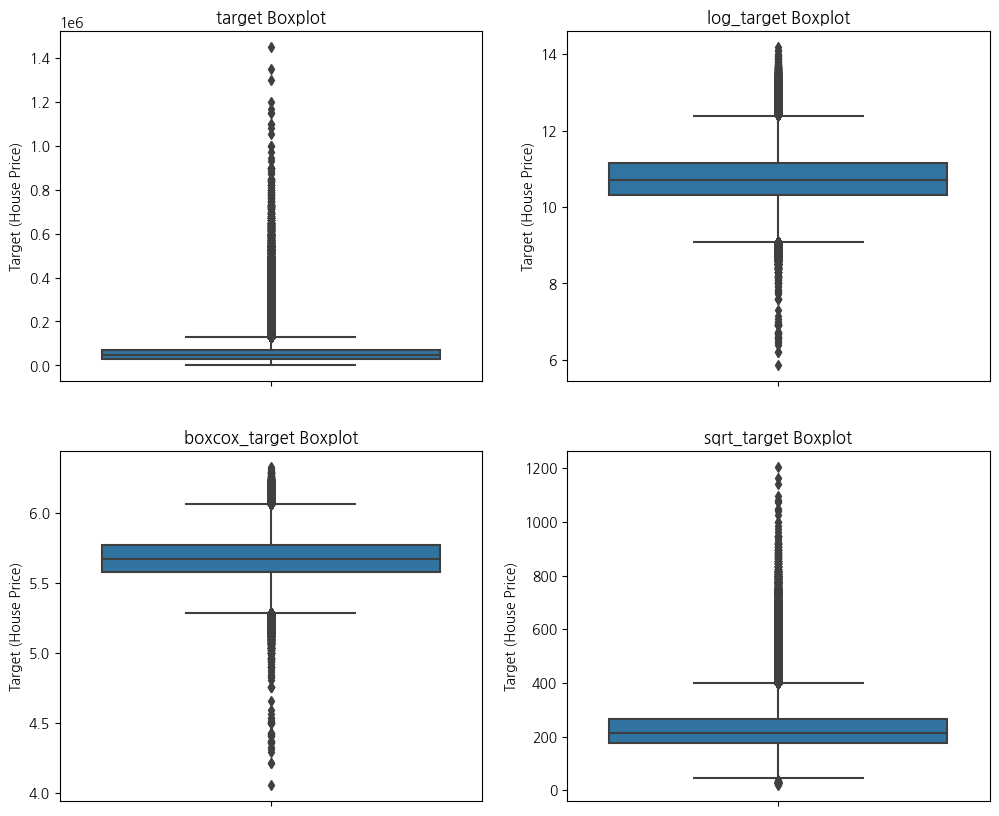

In [51]:
# target 및 각 변환 적용 후 target boxplot 
plt.figure(figsize=(12, 10))

# target
plt.subplot(2, 2, 1)
sns.boxplot(y=df["target"])
plt.title("target Boxplot")
plt.ylabel("Target (House Price)")

# 로그 변환 후 target
plt.subplot(2, 2, 2)
sns.boxplot(y=df["log_target"])
plt.title("log_target Boxplot")
plt.ylabel("Target (House Price)")

# Box-Cox 변환 후 target
plt.subplot(2, 2, 3)
sns.boxplot(y=df["boxcox_target"])
plt.title("boxcox_target Boxplot")
plt.ylabel("Target (House Price)")

# 제곱근 변환 후 target
plt.subplot(2, 2, 4)
sns.boxplot(y=df["sqrt_target"])
plt.title("sqrt_target Boxplot")
plt.ylabel("Target (House Price)")

plt.show()

## 2. 주요 Feature 간 관계 분석
- 집값 예측에 크게 영향을 끼칠 것 같은 주요 Feature 와 Target 간 관계 확인
  - 자치구
    - 자치구 내 행정동 (특정 구만 확인 예정 > premium_areas = ['강남구', '서초구', '송파구'] + 용산구, 성동구)
  - 전용면적

In [9]:
# target_name = "target"
target_name = "log_target"

### 2-1 자치구 / 법정동, Target 간 관계 분석
  - 자치구 내 법정동 별로 boxplot을 그려봤을 때 비슷하거나 편차가 있는 구 확인

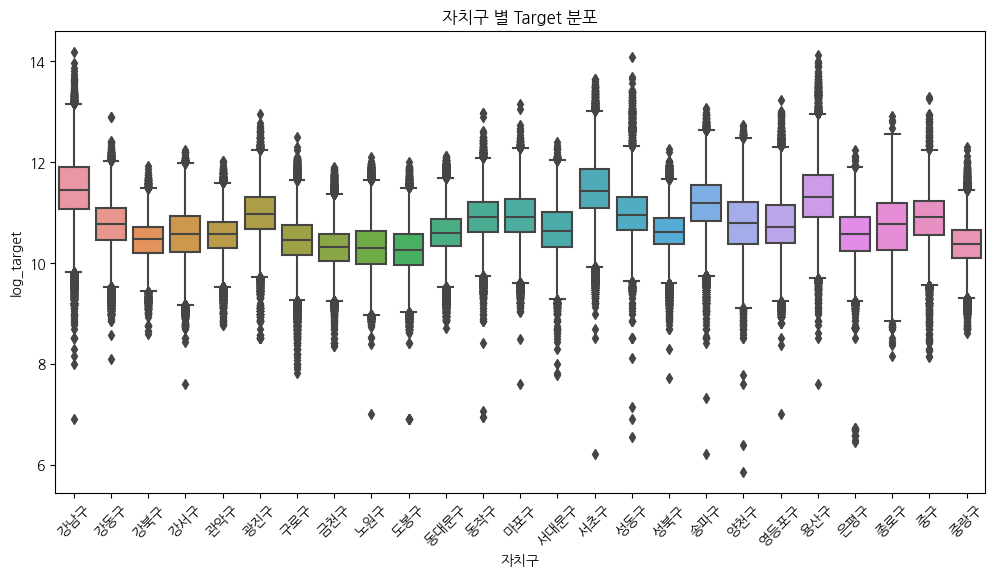

In [10]:
plt.figure(figsize=(12,6))
sns.boxplot(x="자치구", y=target_name, data=df)
plt.xticks(rotation=45)
plt.title("자치구 별 Target 분포")
plt.show()

In [ ]:
def boxplot_by_district(dist_name, target_name, df):
    # Boxplot
    plt.figure(figsize=(12,6))
    sns.boxplot(x="법정동", y=target_name, data=dist_df)
    plt.xticks(rotation=45)
    plt.title(f"{dist_name} 법정동 별 Target 분포")
    plt.show()

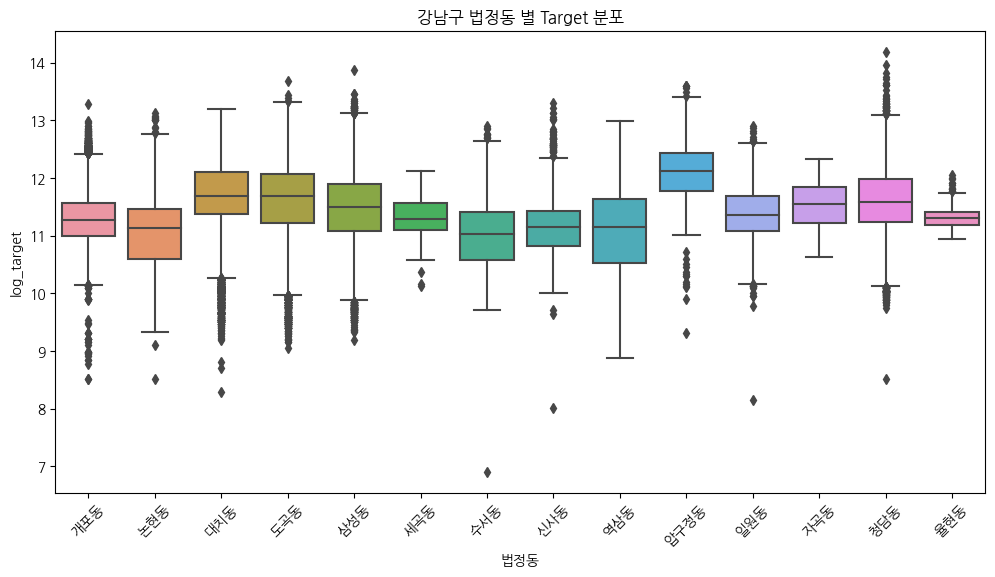

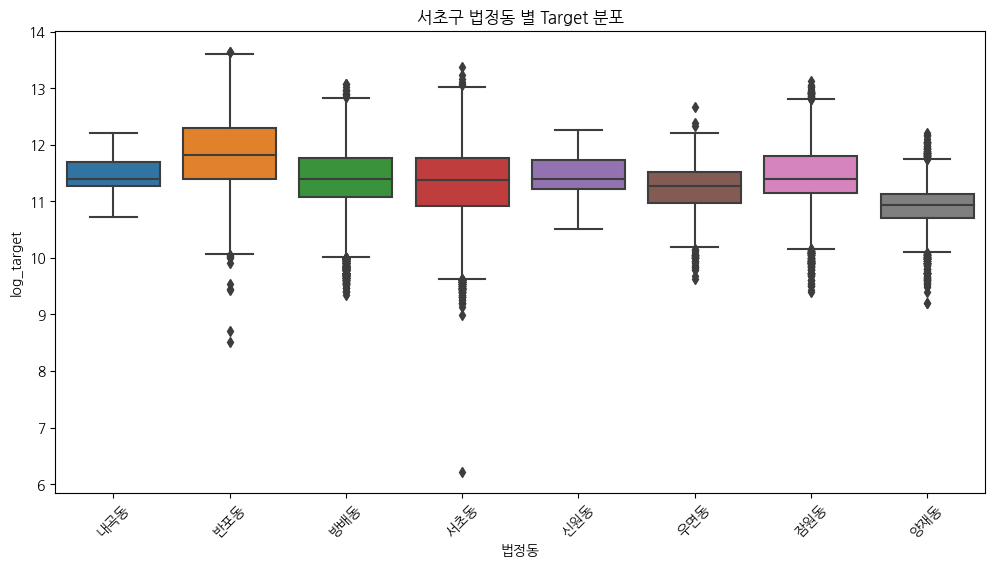

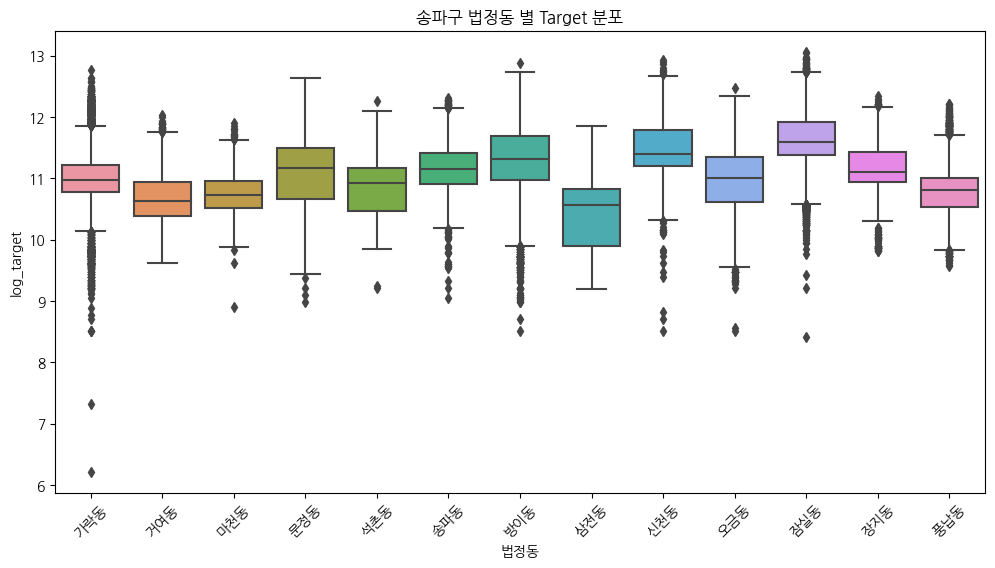

In [12]:
boxplot_by_district("강남구", target_name, df)
boxplot_by_district("서초구", target_name, df)
boxplot_by_district("송파구", target_name, df)

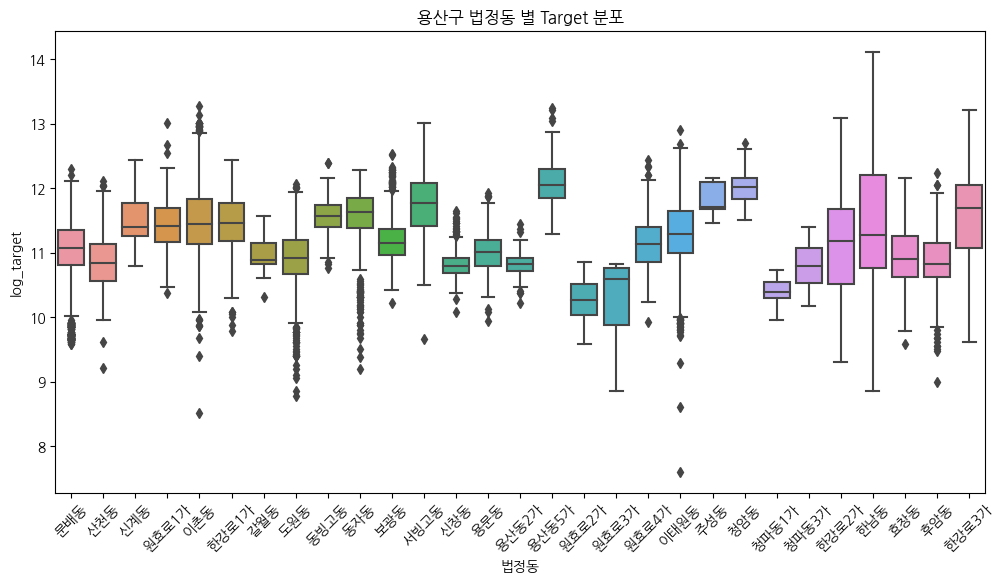

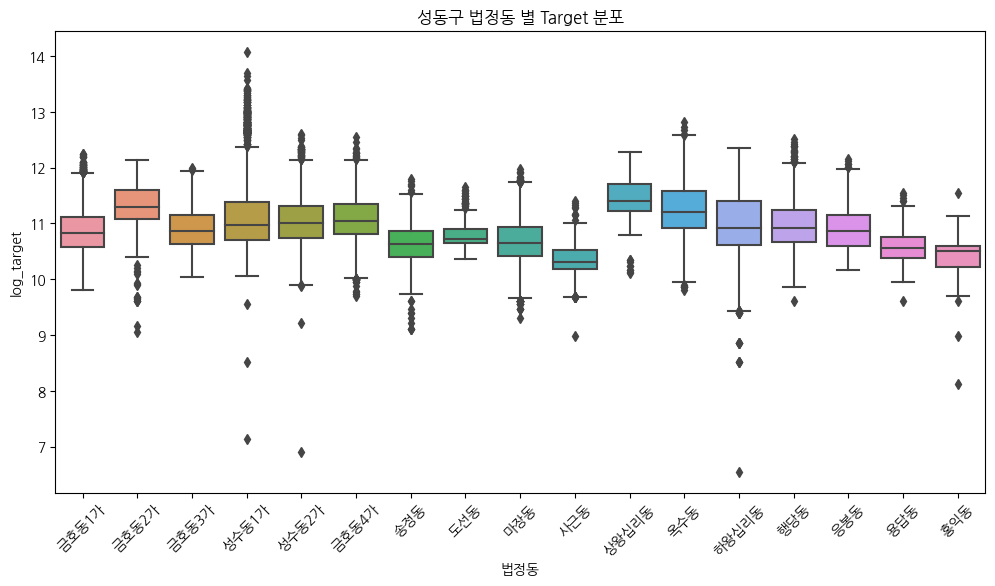

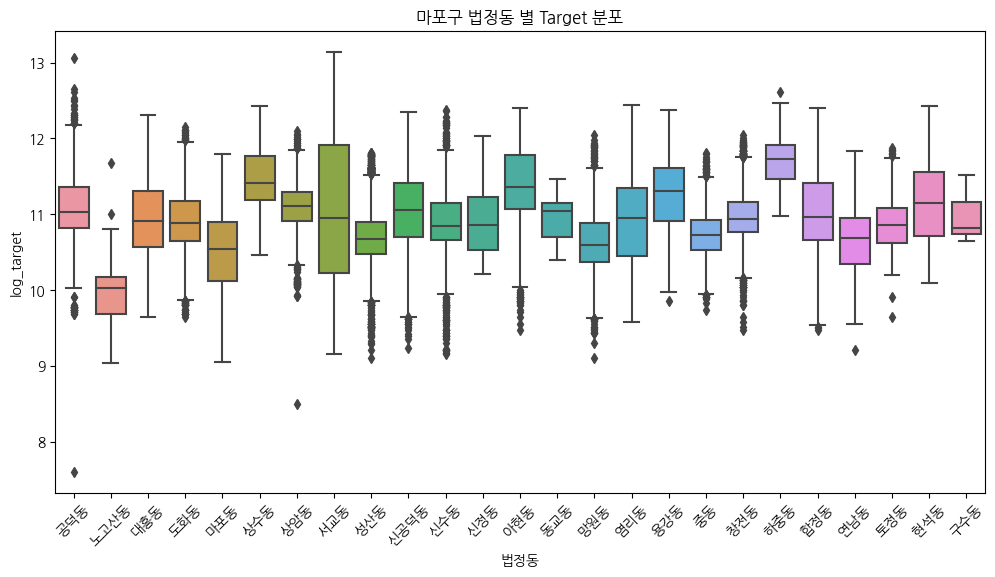

In [13]:
boxplot_by_district("용산구", target_name, df)
boxplot_by_district("성동구", target_name, df)
boxplot_by_district("마포구", target_name, df)

In [68]:
df['단위면적당금액'] = df['target'] / df['전용면적']

In [98]:
def lineplot_by_district(dist_name, target_name, df):
    # 특정 자치구 필터
    dist_df = df[df["자치구"] == dist_name]
    
    # 법정동별 전체 평균 단위면적당금액 계산
    dong_avg = (
        dist_df.groupby('법정동')['단위면적당금액']
        .mean()
        .sort_values(ascending=False)
    )

    # 상위 20개 법정동 목록 (index만 추출)
    top_dongs = dong_avg.head(20).index.tolist()
    # print(top_dongs)

    dist_df = dist_df[dist_df["법정동"].isin(top_dongs)]
    
    # 그룹별 평균 집값 계산
    grouped = (
        dist_df
        .groupby(['법정동', '계약년도'])[target_name]
        .mean()
        .reset_index()
    )
    
    # 시각화
    plt.figure(figsize=(14, 7))
    sns.lineplot(
        data=grouped,
        x='계약년도', y=target_name,
        hue='법정동'
    )
    sns.set_palette("tab20")
    plt.title(f'{dist_name} 내 법정동 별 계약년도 별 평균 {target_name} 추이')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

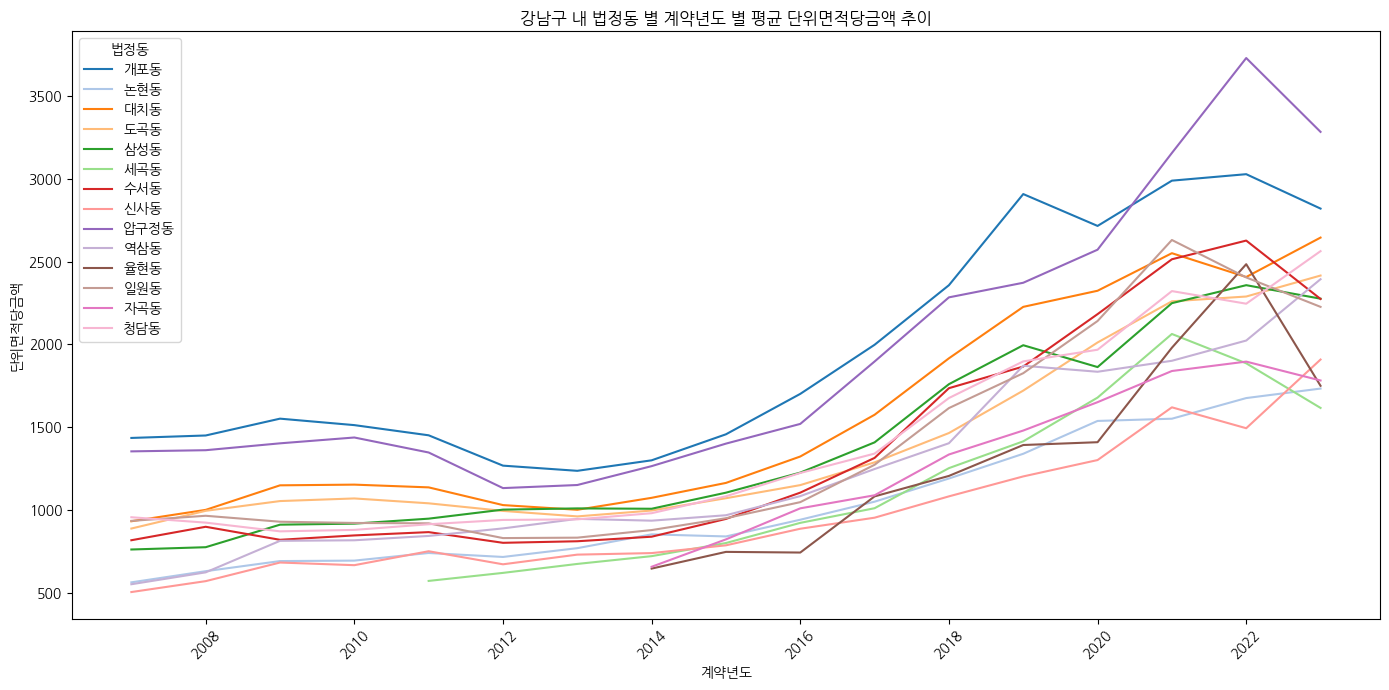

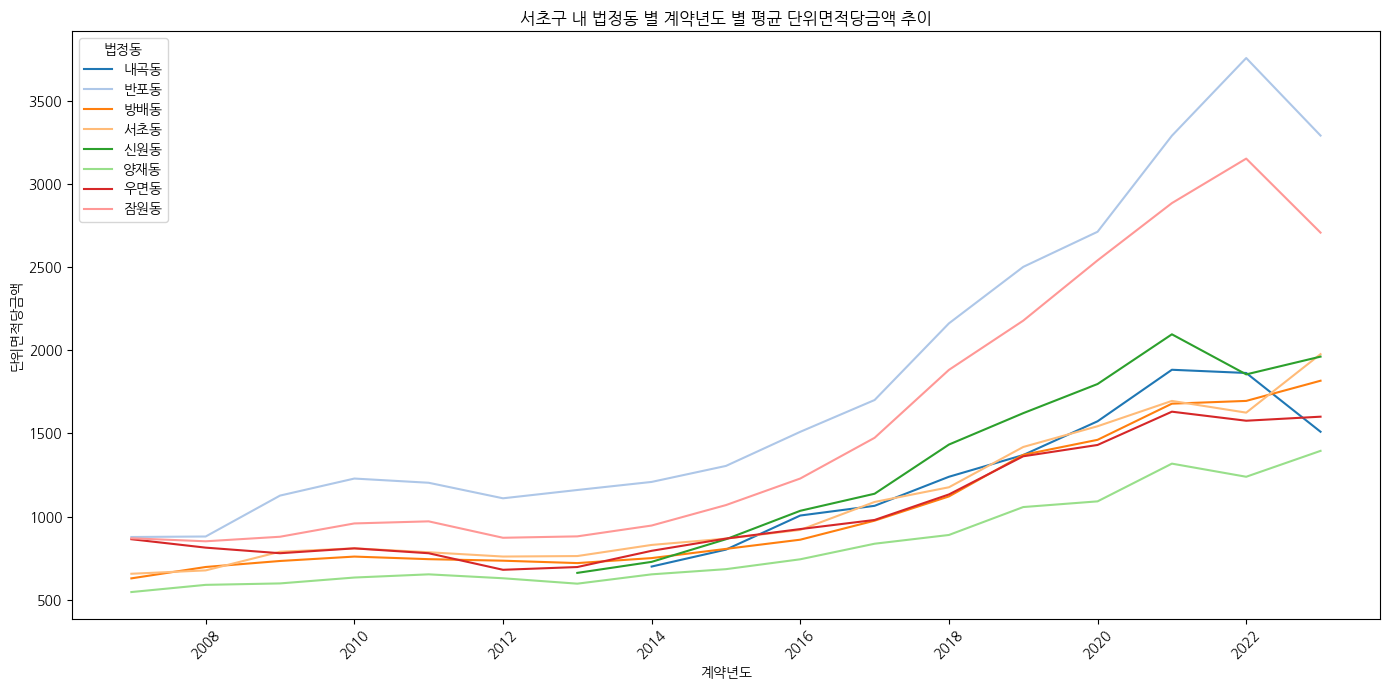

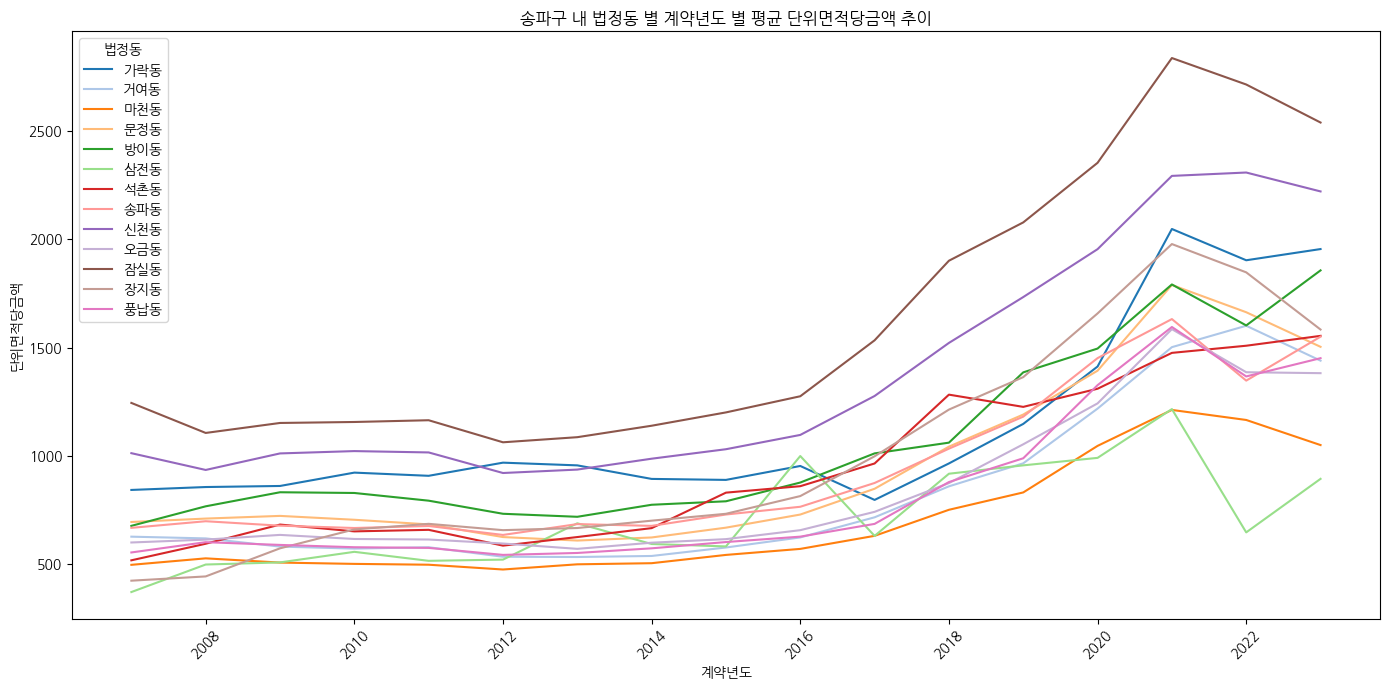

In [99]:
lineplot_by_district("강남구", "단위면적당금액", df)
lineplot_by_district("서초구", "단위면적당금액", df)
lineplot_by_district("송파구", "단위면적당금액", df)

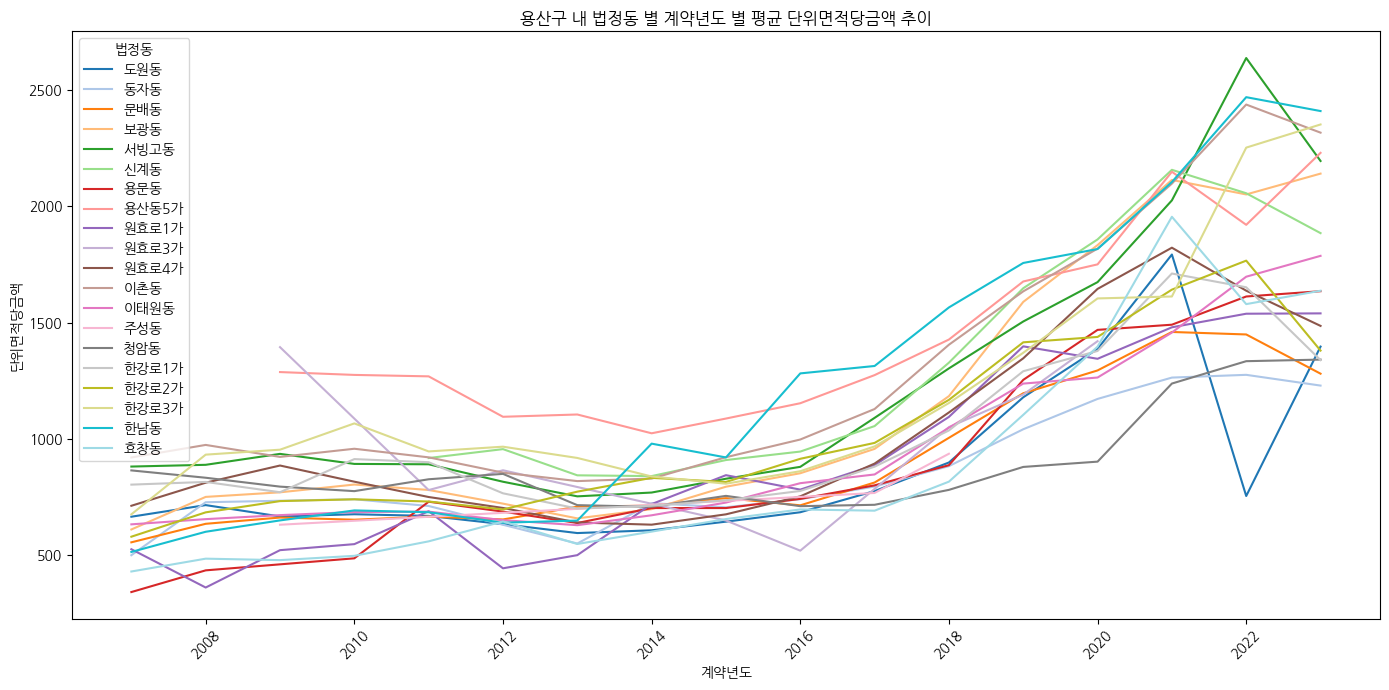

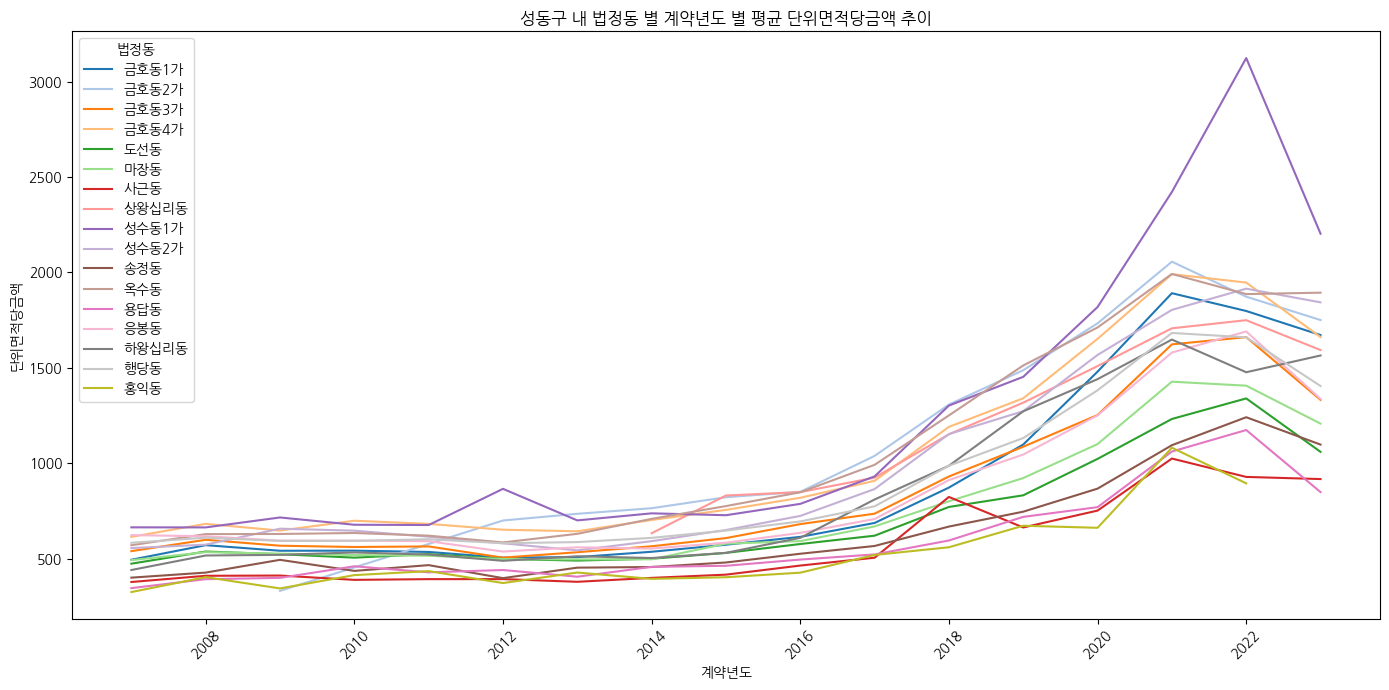

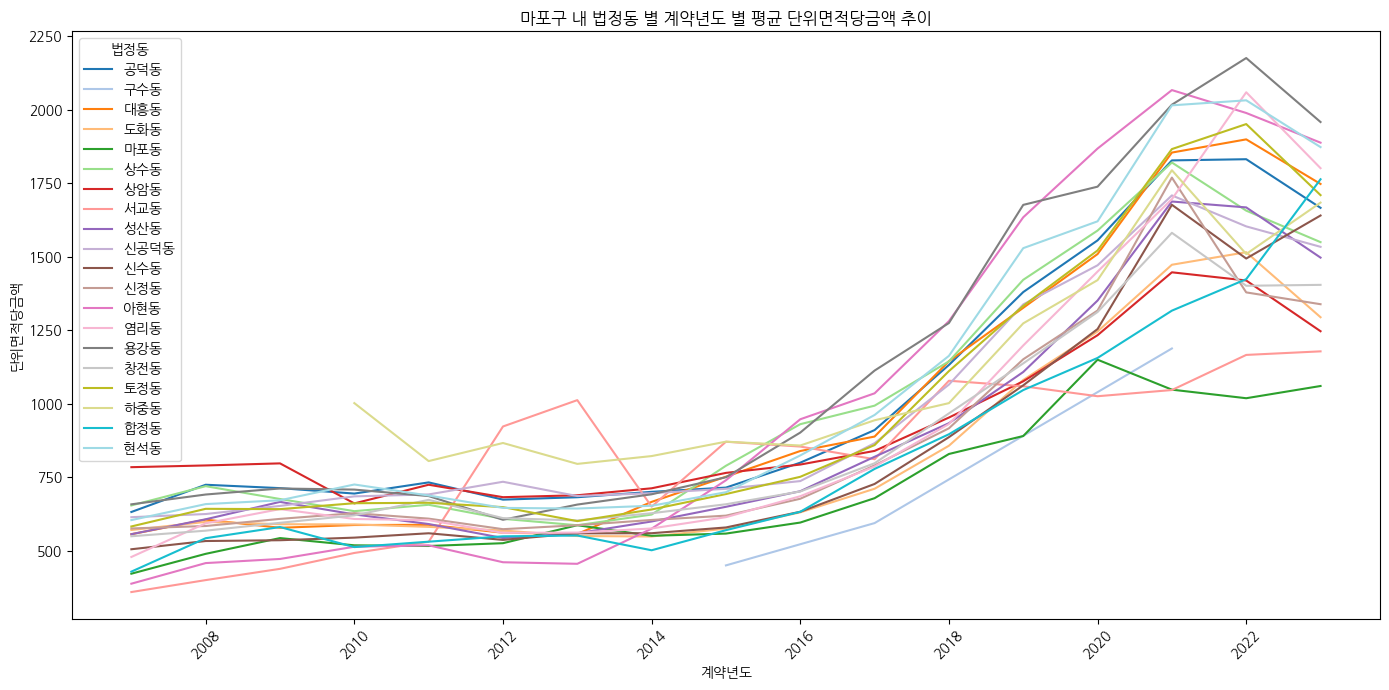

In [100]:
lineplot_by_district("용산구", "단위면적당금액", df)
lineplot_by_district("성동구", "단위면적당금액", df)
lineplot_by_district("마포구", "단위면적당금액", df)

### 2-2 전용면적, Target 간 관계 분석
  - 수치형으로 사용...? 범주형으로 구분해야 할지..?

In [ ]:
grouped = df.groupby('계약년월')['전용면적', 'target'].corr().iloc[0::2, -1]
grouped

/tmp/ipykernel_447677/3113737893.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = df.groupby('계약년월')['전용면적', 'target'].corr().iloc[0::2, -1]


계약년월        
200701  전용면적    0.633637
200702  전용면적    0.645933
200703  전용면적    0.670616
200704  전용면적    0.680327
200705  전용면적    0.663736
                  ...   
202302  전용면적    0.602258
202303  전용면적    0.637580
202304  전용면적    0.666589
202305  전용면적    0.633622
202306  전용면적    0.635668
Name: target, Length: 198, dtype: float64

,전용면적,target
전용면적,1.000000,0.577041
target,0.577041,1.000000


,전용면적,target
전용면적,1.000000,0.597664
target,0.597664,1.000000


<Axes: xlabel='전용면적', ylabel='log_target'>

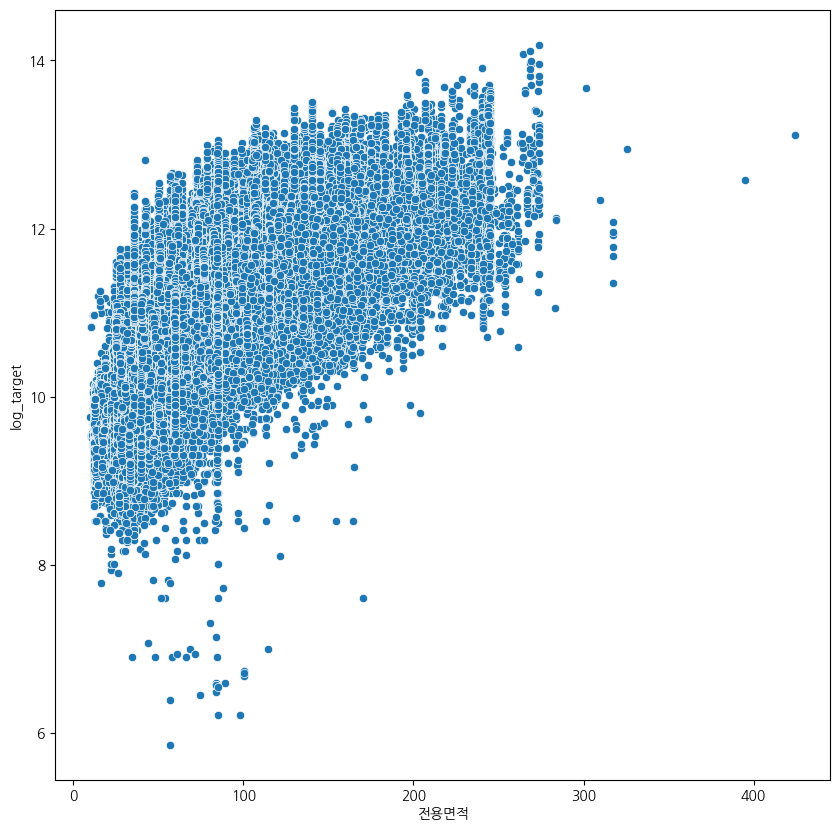

In [ ]:
display(df[["전용면적", "target"]].corr())
display(df[["전용면적", "target"]].corr(method="spearman"))




plt.figure(figsize=(10, 10))
sns.scatterplot(x="전용면적", y=target_name, data=df)

### 2-3 연식(계약년도-건축년도), Target 간 관계 분석
  - 상관계수 : 0.0958

,연식,target
연식,1.000000,0.095837
target,0.095837,1.000000


,연식,target
연식,1.000000,0.046454
target,0.046454,1.000000


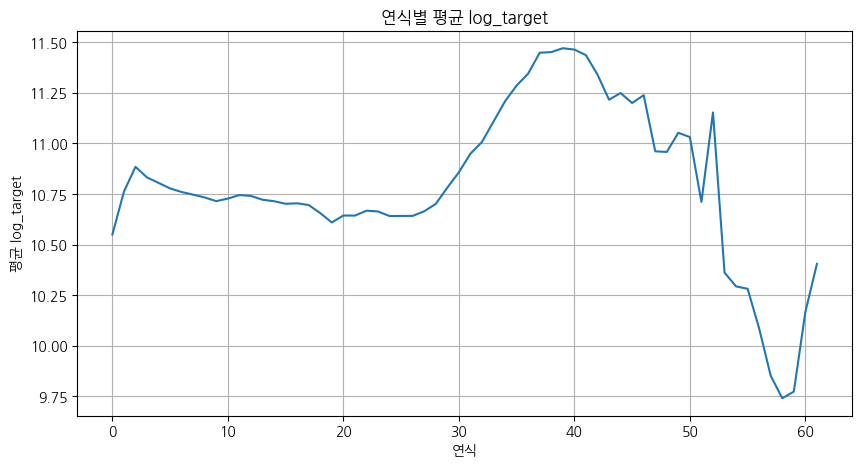

In [ ]:
display(df[["연식", 'target']].corr())
display(df[["연식", "target"]].corr(method="spearman"))

age_avg = df.groupby("연식")["log_target"].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(x="연식", y="log_target", data=age_avg)
plt.title("연식별 평균 log_target")
plt.xlabel("연식")
plt.ylabel("평균 log_target")
plt.grid(True)
plt.show()